In [1]:
# Load the numpy and panda package for linear algebra and data processing
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf

# Imports packages to view data
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import random
from random import sample
import os
import cv2

# Import keras packages
from keras import applications
from tensorflow.keras.optimizers import RMSprop,Adam
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping


In [2]:
def load_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (912, 912))
    return img


def load_dataset(path, label1_count, label2_count):
    dataset = []
    labels = []
    label1_loaded = 0
    label2_loaded = 0
    
    for label in os.listdir(path):
        label_path = os.path.join(path, label)
        
        if label == 'NORMAL' and label1_loaded >= label1_count:
            continue
        elif label == 'PNEUMONIA' and label2_loaded >= label2_count:
            continue
        
        images = os.listdir(label_path)
        selected_images = random.sample(images, min(len(images), label1_count if label == 'NORMAL' else label2_count))
        
        for img in selected_images:
            img_path = os.path.join(label_path, img)
            dataset.append(img_path)
            labels.append(label)
            
            if label == 'NORMAL':
                label1_loaded += 1
            elif label == 'PNEUMONIA':
                label2_loaded += 1
            
            if label1_loaded >= label1_count and label2_loaded >= label2_count:
                break
        
        if label1_loaded >= label1_count and label2_loaded >= label2_count:
            break
    
    df = pd.DataFrame({'image': dataset, 'label': labels})
    return df


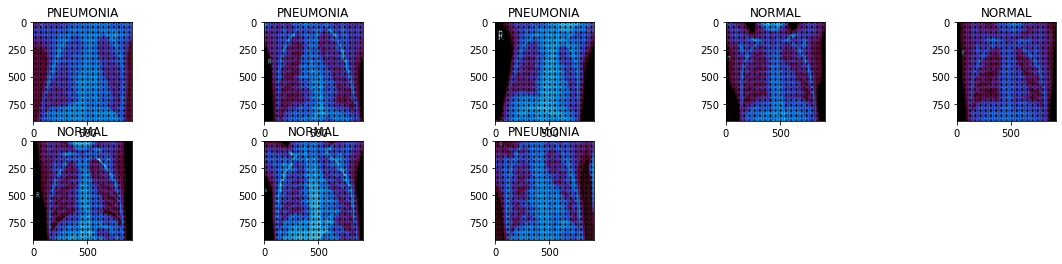

In [3]:

train_df = load_dataset('C:/Users/prati/OneDrive/Desktop/Graduate course/698/H_mask_912/train/', 400, 400)
train_df

test_df = load_dataset('C:/Users/prati/OneDrive/Desktop/Graduate course/698/H_mask_912/test/',label1_count=200, label2_count=200)
test_df

val_df = load_dataset('C:/Users/prati/OneDrive/Desktop/Graduate course/698/H_mask_912/val/',label1_count=8, label2_count=8)
val_df

def plot_sample_data(df, sample_size):
    for i in range(sample_size):
        random_data_location = np.random.randint(df.shape[0])
        plt.subplot(2, 5, i+1)
        plt.imshow(cv2.imread(str(df.iloc[random_data_location]['image'])))
        plt.title(df.iloc[random_data_location]['label'])

plt.figure(figsize=(20,4))
plot_sample_data(train_df, 8)


In [4]:
train_df

,image,label
0,C:/Users/prati/OneDrive/Desktop/Graduate cours...,NORMAL
1,C:/Users/prati/OneDrive/Desktop/Graduate cours...,NORMAL
2,C:/Users/prati/OneDrive/Desktop/Graduate cours...,NORMAL
3,C:/Users/prati/OneDrive/Desktop/Graduate cours...,NORMAL
4,C:/Users/prati/OneDrive/Desktop/Graduate cours...,NORMAL
...,...,...
795,C:/Users/prati/OneDrive/Desktop/Graduate cours...,PNEUMONIA
796,C:/Users/prati/OneDrive/Desktop/Graduate cours...,PNEUMONIA
797,C:/Users/prati/OneDrive/Desktop/Graduate cours...,PNEUMONIA
798,C:/Users/prati/OneDrive/Desktop/Graduate cours...,PNEUMONIA


Found 800 validated image filenames belonging to 2 classes.


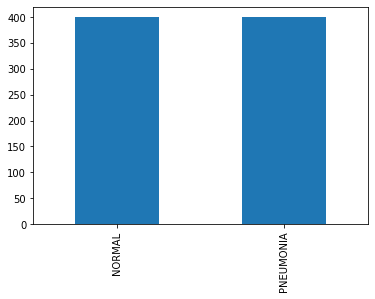

In [5]:

train_df['label'].value_counts().plot(kind = 'bar')

test_df['label'].value_counts().plot(kind = 'bar')

val_df['label'].value_counts().plot(kind = 'bar')

def scaler(img):
    return img

train_aug = ImageDataGenerator(preprocessing_function = scaler)
test_aug = ImageDataGenerator(preprocessing_function = scaler)
val_aug = ImageDataGenerator(preprocessing_function = scaler)

channels = 3
batch_size = 32
img_size = (224, 224)
img_shape = (img_size[0], img_size[1], channels)

train_gen = train_aug.flow_from_dataframe(
    train_df, x_col = 'image', y_col = 'label',batch_size = batch_size,
    target_size = img_size, class_mode = 'categorical',
    color_mode = 'rgb', shuffle = True
)



In [6]:
test_gen = test_aug.flow_from_dataframe(
    test_df, x_col = 'image', y_col = 'label',batch_size = batch_size,
    target_size = img_size, class_mode = 'categorical',
    color_mode = 'rgb', shuffle = True
)


Found 400 validated image filenames belonging to 2 classes.


In [7]:
val_gen = val_aug.flow_from_dataframe(
    val_df, x_col = 'image', y_col = 'label',batch_size = batch_size,
    target_size = img_size, class_mode = 'categorical',
    color_mode = 'rgb', shuffle = True
)

Found 16 validated image filenames belonging to 2 classes.


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16

# Load the VGG-16 Model
base_VGG = tf.keras.applications.VGG16(input_shape=(224, 224, 3),
                                       include_top=False, 
                                       weights='imagenet')
base_VGG.trainable = False

# Add some layers
VGG = tf.keras.Sequential([
        base_VGG,
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.2),
        Dense(512, activation='relu'),
        Dropout(0.2),
        Dense(2,activation='softmax')
        ])

# Compile our model
VGG.compile(loss='categorical_crossentropy', 
            optimizer='adam', 
            metrics=['accuracy', 'Recall', 'Precision'])
VGG.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 1

In [9]:
print(len(base_VGG.layers))

19


In [10]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import regularizers

# Compile the model
VGG.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation
# (Make sure to apply data augmentation during training)
VGG.fit(train_gen, epochs=5, validation_data=val_gen)



Epoch 1/5
25/25 [==============================] - 251s 10s/step - loss: 19.1215 - accuracy: 0.7412 - val_loss: 3.4873 - val_accuracy: 0.8125
Epoch 2/5
25/25 [==============================] - 320s 13s/step - loss: 1.9048 - accuracy: 0.9000 - val_loss: 0.9583 - val_accuracy: 0.8750
Epoch 3/5
25/25 [==============================] - 315s 13s/step - loss: 0.6998 - accuracy: 0.9513 - val_loss: 1.6853 - val_accuracy: 0.8125
Epoch 4/5
25/25 [==============================] - 318s 13s/step - loss: 0.4091 - accuracy: 0.9675 - val_loss: 0.4523 - val_accuracy: 0.9375
Epoch 5/5
25/25 [==============================] - 318s 13s/step - loss: 0.2056 - accuracy: 0.9812 - val_loss: 0.5412 - val_accuracy: 0.9375


In [11]:

# Evaluate the model
test_loss, test_accuracy = VGG.evaluate(test_gen)

13/13 [==============================] - 157s 12s/step - loss: 4.3200 - accuracy: 0.7775
